In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sibur-2-preprocessed/preprocessed_test.csv
/kaggle/input/sibur-2-preprocessed/preprocessed_train.csv
/kaggle/input/sibur20-naming-data/sample_submission.csv
/kaggle/input/sibur20-naming-data/train.csv
/kaggle/input/sibur20-naming-data/test.csv
/kaggle/input/sibur20-naming-data/baseline_submission.csv


In [2]:
!pip install strsimpy

     |████████████████████████████████| 45 kB 149 kB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [4]:
!pip install cyrtranslit

  Created wheel for cyrtranslit: filename=cyrtranslit-0.4-py3-none-any.whl size=5078 sha256=c3113062f58fcfb8e7891bed8dda30717df26a053885392e940ff361ca014d2b
  Stored in directory: /root/.cache/pip/wheels/3a/88/a1/d9d0312064fd0a257cf60f3fe5513bc3c82fe0667712a7add0
Successfully built cyrtranslit
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
!pip install pyod

     |████████████████████████████████| 98 kB 357 kB/s eta 0:00:011
     |████████████████████████████████| 2.1 MB 2.9 MB/s eta 0:00:01
  Created wheel for pyod: filename=pyod-0.8.4-py3-none-any.whl size=112081 sha256=343b19c96ab21962bdf177c0136d4d0a864c824c6b2300784c1db527990835e2
  Stored in directory: /root/.cache/pip/wheels/9f/c9/60/b1311d6e5480f83f29e88bc6223ee1f011e0989a817ad01b65
  Created wheel for combo: filename=combo-0.1.1-py3-none-any.whl size=42113 sha256=65f83513d173dc995b3beccef370059f5c4f50166f6aac4b5f466409430cde93
  Stored in directory: /root/.cache/pip/wheels/3e/e1/f8/08f19ba48f75d3dbbb549cec4b86cc0392c14b2b6bb81f4e1f
  Created wheel for suod: filename=suod-0.0.4-py3-none-any.whl size=2167157 sha256=e405584684a2b5d59d6b4701ad857b7f98f255f6c7ee3ac041b72d89558c5226
  Stored in directory: /root/.cache/pip/wheels/dc/ae/aa/3b8cc857617f3ba6cb9e6b804c79c69d0ed60a08e022e9a4f3
Successfully built pyod combo suod
You should consider upgrading via the '/opt/conda/bin/python3.7 -

In [136]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein
from strsimpy.damerau import Damerau
from strsimpy.optimal_string_alignment import OptimalStringAlignment
from strsimpy.jaro_winkler import JaroWinkler
from strsimpy.longest_common_subsequence import LongestCommonSubsequence
from strsimpy.metric_lcs import MetricLCS
from strsimpy.ngram import NGram
from strsimpy.qgram import QGram
from strsimpy import SIFT4
from catboost import CatBoostClassifier, Pool, cv
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import sparse
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import pycountry
import re
import cyrtranslit
from pyod.models.copod import COPOD
import networkx as nx
import random

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
#random state
RS = 42
np.random.seed(RS)
random.seed(RS)
TRAIN_PATH = '/kaggle/input/sibur20-naming-data/train.csv'
TEST_PATH = '/kaggle/input/sibur20-naming-data/test.csv'

In [8]:
train_full = pd.read_csv(TRAIN_PATH, index_col=0)
test = pd.read_csv(TEST_PATH, index_col=0)
train_full.shape, test.shape

((497819, 3), (213249, 2))

# word preprocessing

Привести к нижнему регистру, кириллицу в транслит, убрать все лишние символы.

In [9]:
train_full["name_1"] = train_full["name_1"].str.lower()
train_full["name_2"] = train_full["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [10]:
train_full["name_1"] = train_full["name_1"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))
train_full["name_2"] = train_full["name_2"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))

test["name_1"] = test["name_1"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))
test["name_2"] = test["name_2"].progress_apply(lambda r: cyrtranslit.to_latin(r, 'ru'))

100%|██████████| 213249/213249 [00:01<00:00, 183589.57it/s]


In [11]:
train_full.replace(re.compile(r"[^\w\s]"), " ", inplace=True)
test.replace(re.compile(r"[^\w\s]"), " ", inplace=True)

In [12]:
train_full.replace(re.compile(r"\d"), " ", inplace=True)
test.replace(re.compile(r"\d"), " ", inplace=True)

# Validation scheme

In [13]:
#compare 4 chars from name_1 and name_2
srez = 4
train_full['4_str'] = train_full['name_1'].str[:srez]
#mask = train_full[train_full['name_1'].str[:srez] == train['name_2'].str[:srez]].copy()

#dict for unique values
dd = dict(zip(train_full['4_str'].unique(), np.arange(len(train_full['4_str'].unique()))))
train_full['4_str'] = train_full['4_str'].map(dd)
#for substr in train['4_str'].value_counts():
    

In [14]:
FOLDS = 5

# array of fold categories
cats = [[] for x in range(FOLDS)]
# array of fold lengths
fold_length = [0] * FOLDS

for x in train_full['4_str'].unique():
    # find fold with minimum length
    min_fold = np.argmin(fold_length)
    num_samples = train_full[train_full['4_str'] == x]['name_1'].count()
    
    cats[min_fold].append(x)
    fold_length[min_fold] += num_samples

print(f'Split complete! {FOLDS} folds in {fold_length} sizes.')

Split complete! 5 folds in [99564, 99564, 99564, 99564, 99563] sizes.


In [15]:
train_cats = cats[0] + cats[1] + cats[2] + cats[3]
val_cats = cats[4]

In [16]:
train = train_full[train_full['4_str'].isin(train_cats)]
valid = train_full[train_full['4_str'].isin(val_cats)]

In [17]:
train.shape, valid.shape

((398256, 4), (99563, 4))

In [18]:
train[train['is_duplicate'] == 1].shape, valid[valid['is_duplicate'] == 1].shape

((2968, 4), (690, 4))

### train graph

Сформировать граф из трейна, где нодами будут слова, а ребрами - связи между соседними словами. Затем удалить из трейна и теста ноды с числом ребер, больших чем порог.

In [19]:
G = nx.Graph()

def fill_graph(s):
    last_word = ''
    for i, word in enumerate(s.split()):
        G.add_node(word)
        if i > 0:
            G.add_edge(word, last_word)
        last_word = word
        
train['name_1'].progress_apply(lambda r: fill_graph(r))
train['name_2'].progress_apply(lambda r: fill_graph(r))

G.number_of_edges(), G.number_of_nodes()

100%|██████████| 398256/398256 [00:04<00:00, 94704.83it/s]


(32498, 16024)

### clear words with hight graph indexes

In [20]:
GRAPH_THRESHOLD = 50

def graph_index(s):
    counter = 0
    for word in s.split():
        try:
            counter += len(list(G.adj[word]))
        except KeyError:
            pass
    return counter

def graph_filter(s):
    result = ''
    for word in s.split():
        if graph_index(word) < GRAPH_THRESHOLD:
            result += word + ' '
    return result.rstrip()

In [21]:
train['name_1'] = train['name_1'].progress_apply(lambda r: graph_filter(r))
train['name_2'] = train['name_2'].progress_apply(lambda r: graph_filter(r))

valid['name_1'] = valid['name_1'].progress_apply(lambda r: graph_filter(r))
valid['name_2'] = valid['name_2'].progress_apply(lambda r: graph_filter(r))

test['name_1'] = test['name_1'].progress_apply(lambda r: graph_filter(r))
test['name_2'] = test['name_2'].progress_apply(lambda r: graph_filter(r))

100%|██████████| 398256/398256 [00:13<00:00, 29690.16it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 398256/398256 [00:13<00:00, 29580.01it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 99563/99563 [00:03<00:00, 30943.39it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: Sett

После удаления частых слов часть имен обратилась в ''. Оценим число, удалим их из трейна.

In [22]:
len(test[(test['name_1'] == '') | (test['name_2'] == '')])

26504

In [23]:
len(train[(train['name_1'] == '') | (train['name_2'] == '')])

49266

Число пострадавших "единичек" из трейна

In [24]:
train[((train['name_1'] == '') | (train['name_2'] == '')) &
      (train['is_duplicate'] == 1)]

,name_1,name_2,is_duplicate,4_str
pair_id,,,,
4647,coim,,1,2129
18076,,applicazioni plastiche industriali,1,970
44517,,chimica organica industriale milanese,1,1351
125170,italia,,1,289
287147,japan,,1,3087
317194,,trinseo api,1,970
390762,api,,1,3657
427186,bst elastomers,,1,3360


In [25]:
train = train[(train['name_1'] != '') & (train['name_2'] != '')]
train.shape

(348990, 4)

# ---------------

In [26]:
#legal_entities = ['ООО', 'ОАО', 'ЗАО', 'ПАО', 'ОДО']

#for entity in tqdm(legal_entities):
#    train.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)
#    test.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)

In [27]:
#legal_entities = ["ltd\.", "co\.", "inc\.", "b\.v\.", "s\.c\.r\.l\.", "gmbh", "pvt\."]

#for entity in tqdm(legal_entities):
#    train.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)
#    test.replace(re.compile(f"\W*{entity}\W*"), "", inplace=True)

In [28]:
# ухудшает скор
#shit_words = ['sa', 's a', 'de', 'cv', 'gmb h', 'g mbh', 'llc', 's pa', 'sp a', 'spa', 'ag', 'rl', 's']

#for shit_word in tqdm(shit_words):
#    train.replace(re.compile('\s+{}'.format(shit_word)), "", inplace=True)
#    test.replace(re.compile(f"\s+{shit_word}\s*"), "", inplace=True)

In [29]:
#countries = [country.name.lower() for country in pycountry.countries]

#for country in tqdm(countries):
#    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
#    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

In [30]:
#print('Dropped', len(train[(train['name_1'] == '') | (train['name_2'] == '')]), 'samples.')

In [31]:
#train = train[(train['name_1'] != '') & (train['name_2'] != '')]

In [32]:
#train[train.is_duplicate==1].sample(15)

In [33]:
#train['name_1'].isna().sum(), train['name_2'].isna().sum(), test['name_1'].isna().sum(), test['name_2'].isna().sum()

# Feature generation

БОЛЬШЕ ФИЧЕЙ ДЛЯ БОГА ФИЧЕЙ!

In [34]:
levenshtein = Levenshtein()
train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
valid["levenstein"] = valid.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:08<00:00, 12047.14it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:19<00:00, 11182.05it/s]


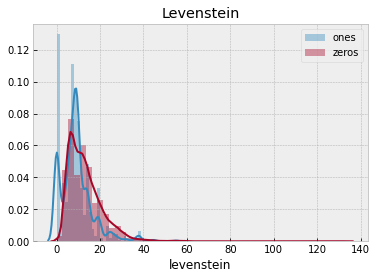

In [35]:
sns.distplot(valid[valid['is_duplicate'] == 1]['levenstein'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['levenstein'], label='zeros')
plt.title('Levenstein')
plt.legend();

In [36]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
valid["norm_levenstein"] = valid.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 99563/99563 [00:08<00:00, 11929.19it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:18<00:00, 11478.06it/s]


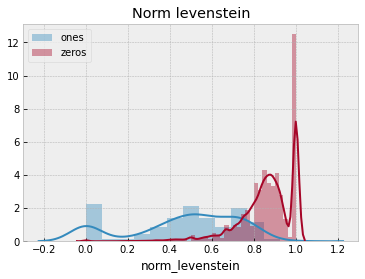

In [37]:
sns.distplot(valid[valid['is_duplicate'] == 1]['norm_levenstein'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['norm_levenstein'], label='zeros')
plt.title('Norm levenstein')
plt.legend();

In [38]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    try:
        res = float(len(c)) / (len(a) + len(b) - len(c))
    except ZeroDivisionError:
        res = 0
    return res

In [39]:
train["jaccard"] = train.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)
valid["jaccard"] = valid.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)
test["jaccard"] = test.progress_apply(lambda r: get_jaccard_sim(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 36824.59it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:05<00:00, 35959.27it/s]


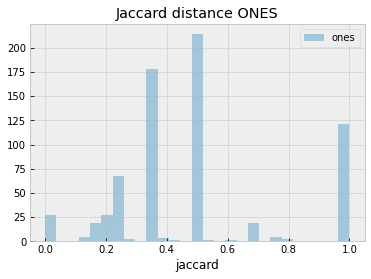

In [40]:
sns.distplot(valid[valid['is_duplicate'] == 1]['jaccard'], label='ones', kde=False)
plt.title('Jaccard distance ONES')
plt.legend();

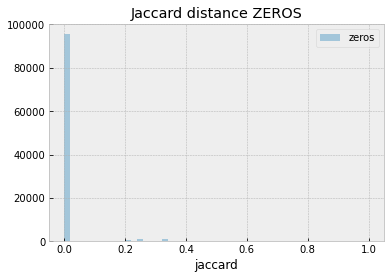

In [41]:
sns.distplot(valid[valid['is_duplicate'] == 0]['jaccard'], label='zeros', kde=False)
plt.title('Jaccard distance ZEROS')
plt.legend();

In [42]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,5))
def ngramm_distance(str_1, str_2):
    vectorizer.fit([str_1 + ' ' + str_2])
    return np.absolute(vectorizer.transform([str_1]) - vectorizer.transform([str_2])).sum()

In [43]:
train["ngramms"] = train.progress_apply(lambda r: ngramm_distance(r.name_1, r.name_2), axis=1)
valid["ngramms"] = valid.progress_apply(lambda r: ngramm_distance(r.name_1, r.name_2), axis=1)
test["ngramms"] = test.progress_apply(lambda r: ngramm_distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [02:09<00:00, 770.32it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [04:34<00:00, 777.75it/s]


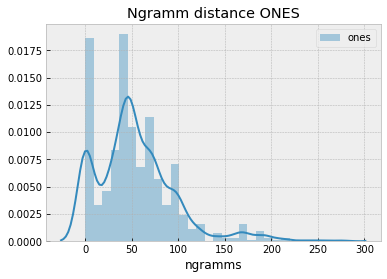

In [44]:
sns.distplot(valid[valid['is_duplicate'] == 1]['ngramms'], label='ones')
plt.title('Ngramm distance ONES')
plt.legend();

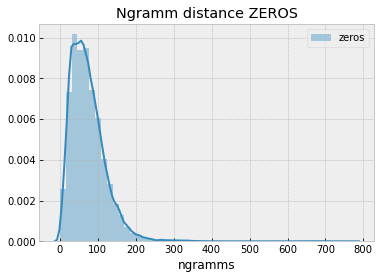

In [45]:
sns.distplot(valid[valid['is_duplicate'] == 0]['ngramms'], label='zeros')
plt.title('Ngramm distance ZEROS')
plt.legend();

In [46]:
def calc_1_in_2(str_1, str_2):
    if str_1 == '':
        return 0
    word = str_1.split()[0]
    return int(word in str_2)

In [47]:
train["1_in_2"] = train.progress_apply(lambda r: calc_1_in_2(r.name_1, r.name_2), axis=1)
valid["1_in_2"] = valid.progress_apply(lambda r: calc_1_in_2(r.name_1, r.name_2), axis=1)
test["1_in_2"] = test.progress_apply(lambda r: calc_1_in_2(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 40656.68it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:05<00:00, 36949.85it/s]


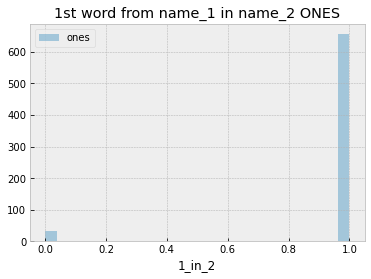

In [48]:
sns.distplot(valid[valid['is_duplicate'] == 1]['1_in_2'], label='ones', kde=False)
plt.title('1st word from name_1 in name_2 ONES')
plt.legend();

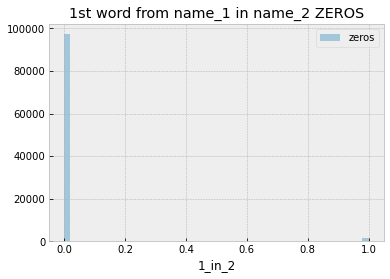

In [49]:
sns.distplot(valid[valid['is_duplicate'] == 0]['1_in_2'], label='zeros', kde=False)
plt.title('1st word from name_1 in name_2 ZEROS')
plt.legend();

In [50]:
train["2_in_1"] = train.progress_apply(lambda r: calc_1_in_2(r.name_2, r.name_1), axis=1)
valid["2_in_1"] = valid.progress_apply(lambda r: calc_1_in_2(r.name_2, r.name_1), axis=1)
test["2_in_1"] = test.progress_apply(lambda r: calc_1_in_2(r.name_2, r.name_1), axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 38331.53it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:05<00:00, 38706.11it/s]


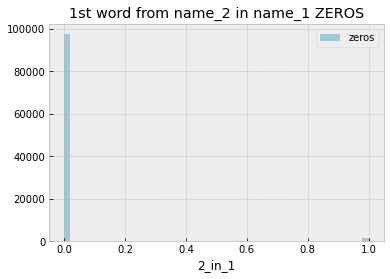

In [51]:
sns.distplot(valid[valid['is_duplicate'] == 0]['2_in_1'], label='zeros', kde=False)
plt.title('1st word from name_2 in name_1 ZEROS')
plt.legend();

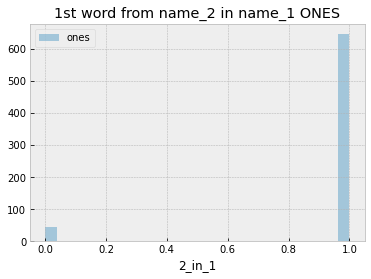

In [52]:
sns.distplot(valid[valid['is_duplicate'] == 1]['2_in_1'], label='ones', kde=False)
plt.title('1st word from name_2 in name_1 ONES')
plt.legend();

In [53]:
train['name_1_joined'] = train['name_1'].str.replace(' ', '')
train['name_2_joined'] = train['name_2'].str.replace(' ', '')

valid['name_1_joined'] = valid['name_1'].str.replace(' ', '')
valid['name_2_joined'] = valid['name_2'].str.replace(' ', '')

test['name_1_joined'] = test['name_1'].str.replace(' ', '')
test['name_2_joined'] = test['name_2'].str.replace(' ', '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [54]:
train["jaccard_joined"] = train.progress_apply(lambda r: get_jaccard_sim(r.name_1_joined, r.name_2_joined), axis=1)
valid["jaccard_joined"] = valid.progress_apply(lambda r: get_jaccard_sim(r.name_1_joined, r.name_2_joined), axis=1)
test["jaccard_joined"] = test.progress_apply(lambda r: get_jaccard_sim(r.name_1_joined, r.name_2_joined), axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 35387.78it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:05<00:00, 37299.07it/s]


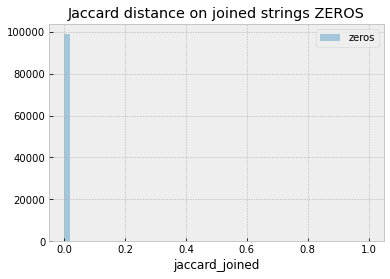

In [55]:
sns.distplot(valid[valid['is_duplicate'] == 0]['jaccard_joined'], label='zeros', kde=False)
plt.title('Jaccard distance on joined strings ZEROS')
plt.legend();

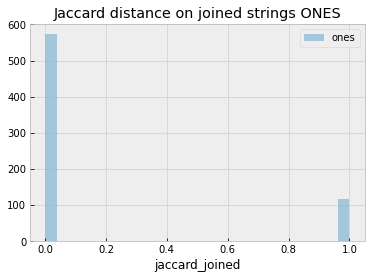

In [56]:
sns.distplot(valid[valid['is_duplicate'] == 1]['jaccard_joined'], label='ones', kde=False)
plt.title('Jaccard distance on joined strings ONES')
plt.legend();

In [57]:
levenshtein = Levenshtein()
train["levenstein_joined"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                  axis=1)
valid["levenstein_joined"] = valid.progress_apply(lambda r: levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                  axis=1)
test["levenstein_joined"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                axis=1)

100%|██████████| 99563/99563 [00:07<00:00, 13426.07it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 213249/213249 [00:16<00:00, 12687.97it/s]


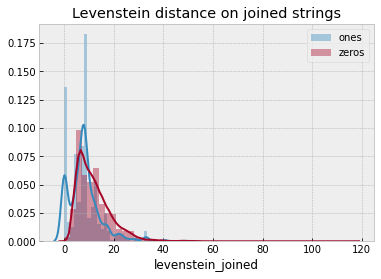

In [58]:
sns.distplot(valid[valid['is_duplicate'] == 1]['levenstein_joined'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['levenstein_joined'], label='zeros')
plt.title('Levenstein distance on joined strings')
plt.legend();

In [59]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein_joined"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                axis=1)
valid["norm_levenstein_joined"] = valid.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                                axis=1)
test["norm_levenstein_joined"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1_joined, r.name_2_joined),
                                              axis=1)

100%|██████████| 99563/99563 [00:07<00:00, 13034.95it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:17<00:00, 12387.79it/s]


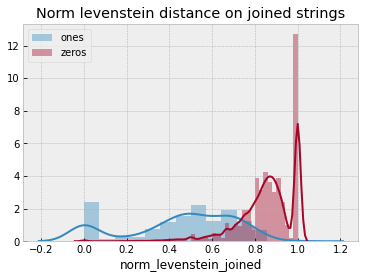

In [60]:
sns.distplot(valid[valid['is_duplicate'] == 1]['norm_levenstein_joined'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['norm_levenstein_joined'], label='zeros')
plt.title('Norm levenstein distance on joined strings')
plt.legend();

In [61]:
train["num_chars"] = train.progress_apply(lambda r: np.absolute(len(r.name_1_joined) - len(r.name_2_joined)),
                                          axis=1)
valid["num_chars"] = valid.progress_apply(lambda r: np.absolute(len(r.name_1_joined) - len(r.name_2_joined)),
                                          axis=1)
test["num_chars"] = test.progress_apply(lambda r: np.absolute(len(r.name_1_joined) - len(r.name_2_joined)),
                                        axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 37355.93it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 213249/213249 [00:06<00:00, 34890.07it/s]


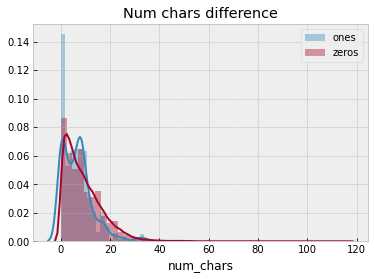

In [62]:
sns.distplot(valid[valid['is_duplicate'] == 1]['num_chars'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['num_chars'], label='zeros')
plt.title('Num chars difference')
plt.legend();

In [63]:
train["num_words"] = train.progress_apply(lambda r: np.absolute(len(r.name_1_joined.split()) - len(r.name_2_joined.split())),
                                          axis=1)
valid["num_words"] = valid.progress_apply(lambda r: np.absolute(len(r.name_1_joined.split()) - len(r.name_2_joined.split())),
                                          axis=1)
test["num_words"] = test.progress_apply(lambda r: np.absolute(len(r.name_1_joined.split()) - len(r.name_2_joined.split())),
                                        axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 37415.69it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 213249/213249 [00:06<00:00, 35123.08it/s]


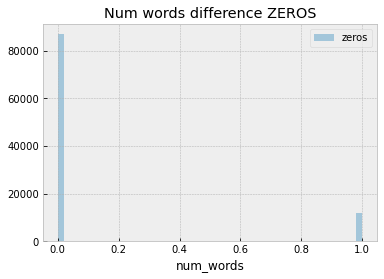

In [64]:
sns.distplot(valid[valid['is_duplicate'] == 0]['num_words'], label='zeros', kde=False)
plt.title('Num words difference ZEROS')
plt.legend();

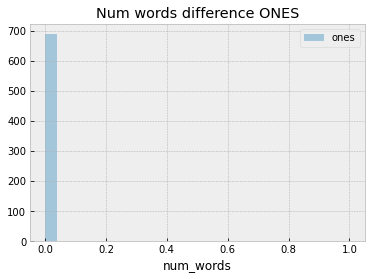

In [65]:
sns.distplot(valid[valid['is_duplicate'] == 1]['num_words'], label='ones', kde=False)
plt.title('Num words difference ONES')
plt.legend();

In [66]:
def _subseq_count(str_1, str_2):
    counter = 0
    subs = []
    str = ''
    for char in str_1:
        str += char
        subs.append(str)
    for s in subs:
        if s in str_2:
            counter += len(s)
    return counter

def subseq_count(str_1, str_2):
    count = 0
    for i, s in enumerate(str_1):
        count += _subseq_count(str_1[i:], str_2)
    return count

In [67]:
train["subseq_rate"] = train.progress_apply(lambda r: subseq_count(r.name_1_joined, r.name_2_joined) +
                                            subseq_count(r.name_2_joined, r.name_1_joined), axis=1)
valid["subseq_rate"] = valid.progress_apply(lambda r: subseq_count(r.name_1_joined, r.name_2_joined) +
                                            subseq_count(r.name_2_joined, r.name_1_joined), axis=1)
test["subseq_rate"] = test.progress_apply(lambda r: subseq_count(r.name_1_joined, r.name_2_joined) +
                                          subseq_count(r.name_2_joined, r.name_1_joined), axis=1)

100%|██████████| 99563/99563 [00:09<00:00, 10931.90it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 213249/213249 [00:19<00:00, 10683.64it/s]


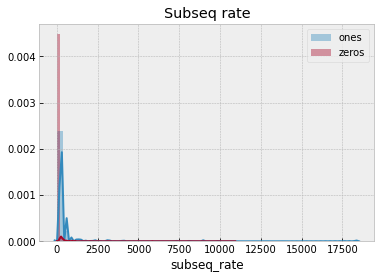

In [68]:
sns.distplot(valid[valid['is_duplicate'] == 1]['subseq_rate'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['subseq_rate'], label='zeros')
plt.title('Subseq rate')
plt.legend();

In [69]:
def word_compare(str_1, str_2):
    count = 0
    words = str_1.split()
    for word in words:
        if word in str_2:
            count += 1
    return count

In [70]:
train["word_compare"] = train.progress_apply(lambda r: word_compare(r.name_1, r.name_2), axis=1)
valid["word_compare"] = valid.progress_apply(lambda r: word_compare(r.name_1, r.name_2), axis=1)
test["word_compare"] = test.progress_apply(lambda r: word_compare(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:02<00:00, 39831.67it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:05<00:00, 36809.82it/s]


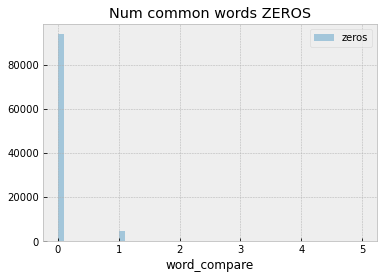

In [71]:
sns.distplot(valid[valid['is_duplicate'] == 0]['word_compare'], label='zeros', kde=False)
plt.title('Num common words ZEROS')
plt.legend();

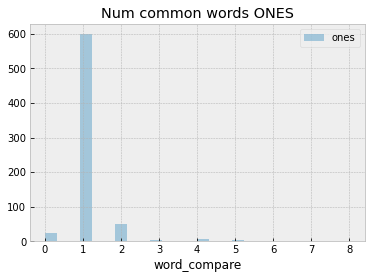

In [72]:
sns.distplot(valid[valid['is_duplicate'] == 1]['word_compare'], label='ones', kde=False)
plt.title('Num common words ONES')
plt.legend();

### word indexes

In [73]:
train["sum_word_index"] = train.progress_apply(lambda r: graph_index(r.name_1 + ' ' + r.name_2), axis=1)
valid["sum_word_index"] = valid.progress_apply(lambda r: graph_index(r.name_1 + ' ' + r.name_2), axis=1)
test["sum_word_index"] = test.progress_apply(lambda r: graph_index(r.name_1 + ' ' + r.name_2), axis=1)

100%|██████████| 99563/99563 [00:04<00:00, 24762.11it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:08<00:00, 25697.55it/s]


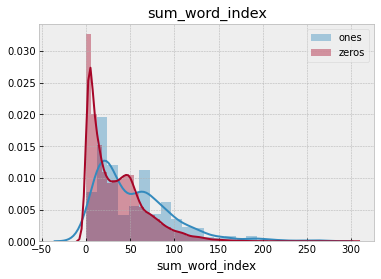

In [74]:
sns.distplot(valid[valid['is_duplicate'] == 1]['sum_word_index'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['sum_word_index'], label='zeros')
plt.title('sum_word_index')
plt.legend();

### Demarou

In [75]:
damerau = Damerau()
train["damerau"] = train.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)
valid["damerau"] = valid.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)
test["damerau"] = test.progress_apply(lambda r: damerau.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:16<00:00, 5992.25it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:37<00:00, 5639.97it/s]


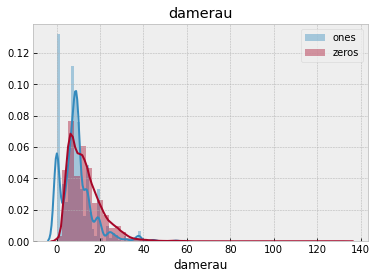

In [76]:
sns.distplot(valid[valid['is_duplicate'] == 1]['damerau'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['damerau'], label='zeros')
plt.title('damerau')
plt.legend();

### Optimal String Alignment

In [77]:
optimal_string_alignment = OptimalStringAlignment()
train["optimal_string_alignment"] = train.progress_apply(lambda r: optimal_string_alignment.distance(r.name_1, r.name_2),
                                                         axis=1)
valid["optimal_string_alignment"] = valid.progress_apply(lambda r: optimal_string_alignment.distance(r.name_1, r.name_2),
                                                         axis=1)
test["optimal_string_alignment"] = test.progress_apply(lambda r: optimal_string_alignment.distance(r.name_1, r.name_2),
                                                       axis=1)

100%|██████████| 99563/99563 [00:12<00:00, 8063.20it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
100%|██████████| 213249/213249 [00:27<00:00, 7733.54it/s]


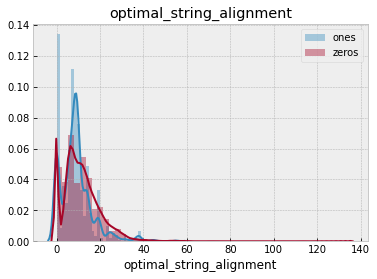

In [78]:
sns.distplot(valid[valid['is_duplicate'] == 1]['optimal_string_alignment'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['optimal_string_alignment'], label='zeros')
plt.title('optimal_string_alignment')
plt.legend();

### Jaro-Winkler

In [79]:
jarowinkler = JaroWinkler()
train["jarowinkler"] = train.progress_apply(lambda r: jarowinkler.similarity(r.name_1, r.name_2), axis=1)
valid["jarowinkler"] = valid.progress_apply(lambda r: jarowinkler.similarity(r.name_1, r.name_2), axis=1)
test["jarowinkler"] = test.progress_apply(lambda r: jarowinkler.similarity(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:04<00:00, 22330.61it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:10<00:00, 20964.89it/s]


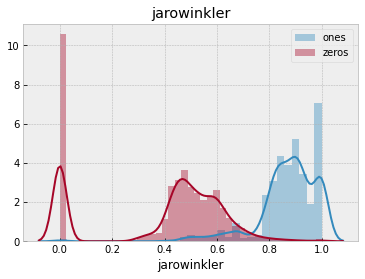

In [80]:
sns.distplot(valid[valid['is_duplicate'] == 1]['jarowinkler'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['jarowinkler'], label='zeros')
plt.title('jarowinkler')
plt.legend();

### Longest Common Subsequence

In [81]:
lcs = LongestCommonSubsequence()
train["lcs_length"] = train.progress_apply(lambda r: lcs.length(r.name_1, r.name_2), axis=1)
valid["lcs_length"] = valid.progress_apply(lambda r: lcs.length(r.name_1, r.name_2), axis=1)
test["lcs_length"] = test.progress_apply(lambda r: lcs.length(r.name_1, r.name_2), axis=1)
train["lcs_distance"] = train.progress_apply(lambda r: lcs.distance(r.name_1, r.name_2), axis=1)
valid["lcs_distance"] = valid.progress_apply(lambda r: lcs.distance(r.name_1, r.name_2), axis=1)
test["lcs_distance"] = test.progress_apply(lambda r: lcs.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:08<00:00, 11455.39it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 99563/99563 [00:09<00:00, 10956.65it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
100%|██████████| 213249/213249 [00:18<00:00, 11290.92it/s]


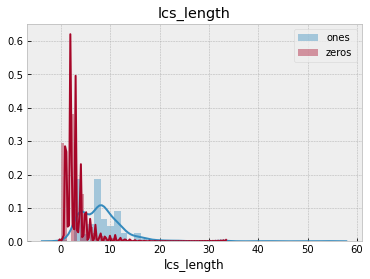

In [82]:
sns.distplot(valid[valid['is_duplicate'] == 1]['lcs_length'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['lcs_length'], label='zeros')
plt.title('lcs_length')
plt.legend();

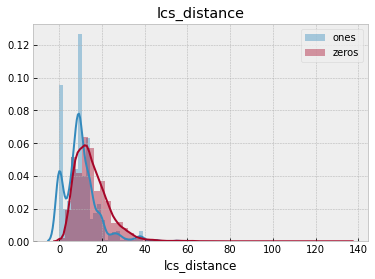

In [83]:
sns.distplot(valid[valid['is_duplicate'] == 1]['lcs_distance'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['lcs_distance'], label='zeros')
plt.title('lcs_distance')
plt.legend();

### MetricLCS

In [84]:
metric_lcs = MetricLCS()
train["metric_lcs"] = train.progress_apply(lambda r: metric_lcs.distance(r.name_1, r.name_2), axis=1)
valid["metric_lcs"] = valid.progress_apply(lambda r: metric_lcs.distance(r.name_1, r.name_2), axis=1)
test["metric_lcs"] = test.progress_apply(lambda r: metric_lcs.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:08<00:00, 11300.67it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:19<00:00, 11127.81it/s]


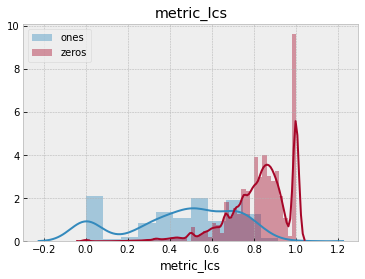

In [85]:
sns.distplot(valid[valid['is_duplicate'] == 1]['metric_lcs'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['metric_lcs'], label='zeros')
plt.title('metric_lcs')
plt.legend();

### twogram

In [86]:
twogram = NGram(2)
train["twogram"] = train.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)
valid["twogram"] = valid.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)
test["twogram"] = test.progress_apply(lambda r: twogram.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:17<00:00, 5627.88it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:39<00:00, 5377.89it/s]


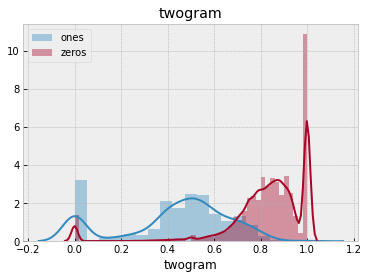

In [87]:
sns.distplot(valid[valid['is_duplicate'] == 1]['twogram'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['twogram'], label='zeros')
plt.title('twogram')
plt.legend();

### Qgram

In [88]:
qgram = QGram(2)
train["qgram"] = train.progress_apply(lambda r: qgram.distance(r.name_1, r.name_2), axis=1)
valid["qgram"] = valid.progress_apply(lambda r: qgram.distance(r.name_1, r.name_2), axis=1)
test["qgram"] = test.progress_apply(lambda r: qgram.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:06<00:00, 15274.78it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:13<00:00, 15291.58it/s]


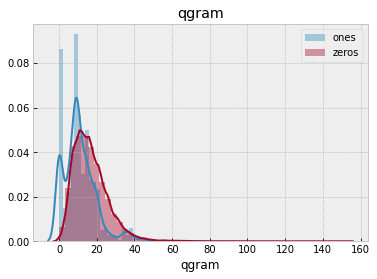

In [89]:
sns.distplot(valid[valid['is_duplicate'] == 1]['qgram'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['qgram'], label='zeros')
plt.title('qgram')
plt.legend();

### SIFT4

In [90]:
sift = SIFT4()
train["sift"] = train.progress_apply(lambda r: sift.distance(r.name_1, r.name_2), axis=1)
valid["sift"] = valid.progress_apply(lambda r: sift.distance(r.name_1, r.name_2), axis=1)
test["sift"] = test.progress_apply(lambda r: sift.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 99563/99563 [00:06<00:00, 16347.05it/s]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 213249/213249 [00:13<00:00, 15286.83it/s]


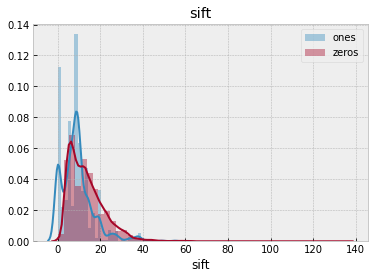

In [91]:
sns.distplot(valid[valid['is_duplicate'] == 1]['sift'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['sift'], label='zeros')
plt.title('sift')
plt.legend();

# Pseudo-labeling

In [92]:
def vectorize(X_train, X_valid, X_test, vectorizer):
   
    vectorizer.fit(X_train[:, 0] + ' ' + X_train[:, 1])
    X_train_ngramms = np.absolute(vectorizer.transform(X_train[:, 0]) - vectorizer.transform(X_train[:, 1]))
    X_valid_ngramms = np.absolute(vectorizer.transform(X_valid[:, 0]) - vectorizer.transform(X_valid[:, 1]))
    X_test_ngramms = np.absolute(vectorizer.transform(X_test[:, 0]) - vectorizer.transform(X_test[:, 1]))
    
    return X_train_ngramms, X_valid_ngramms, X_test_ngramms

    
def scale(X_train, X_valid, X_test, scaler):
    X_train_scaled = scaler.fit_transform(X_train).astype(np.float)
    X_valid_scaled = scaler.transform(X_valid).astype(np.float)
    X_test_scaled = scaler.transform(X_test).astype(np.float)
    
    return X_train_scaled, X_valid_scaled, X_test_scaled

In [93]:
exclude_columns = ['name_1', 'name_2', 'name_1_joined', 'name_2_joined', '4_str']
columns = train.drop(exclude_columns + ['is_duplicate'], axis=1).columns
columns_names = ['name_1', 'name_2']

vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,5), max_features=5000)
scaler = StandardScaler()

columns

Index(['levenstein', 'norm_levenstein', 'jaccard', 'ngramms', '1_in_2',
       '2_in_1', 'jaccard_joined', 'levenstein_joined',
       'norm_levenstein_joined', 'num_chars', 'num_words', 'subseq_rate',
       'word_compare', 'sum_word_index', 'damerau', 'optimal_string_alignment',
       'jarowinkler', 'lcs_length', 'lcs_distance', 'metric_lcs', 'twogram',
       'qgram', 'sift'],
      dtype='object')

### linear regression

In [94]:
X_train = train[columns_names].values
X_valid = valid[columns_names].values
X_test = test[columns_names].values
y_train = train['is_duplicate'].values

X_train, X_valid, X_test = vectorize(X_train, X_valid, X_test, vectorizer)

# Регрессия - только на н-граммах, остальные фичи не добавляем
lr = LogisticRegression(random_state=RS, verbose=True, class_weight='balanced', C=0.01,
                        n_jobs=-1).fit(X_train, y_train)

train['lr_labels'] = lr.predict_proba(X_train)[:, 1]
valid['lr_labels'] = lr.predict_proba(X_valid)[:, 1]
test['lr_labels'] = lr.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   16.5s finished
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


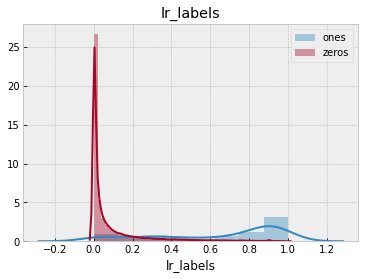

In [95]:
sns.distplot(valid[valid['is_duplicate'] == 1]['lr_labels'], label='ones')
sns.distplot(valid[valid['is_duplicate'] == 0]['lr_labels'], label='zeros')
plt.title('lr_labels')
plt.legend();

### kmeans

In [96]:
clustering = KMeans(n_clusters=20, random_state=RS).fit(X_train)
train['kmeans_labels'] = clustering.predict(X_train)
valid['kmeans_labels'] = clustering.predict(X_valid)
test['kmeans_labels'] = clustering.predict(X_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


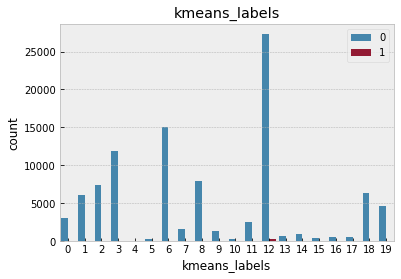

In [97]:
sns.countplot(data=valid, x='kmeans_labels', hue='is_duplicate')
plt.title('kmeans_labels')
plt.legend();

In [98]:
enc = OneHotEncoder(drop='first')
OHE_train = enc.fit_transform(train['kmeans_labels'].values.reshape(-1, 1))
OHE_valid = enc.transform(valid['kmeans_labels'].values.reshape(-1, 1))
OHE_test = enc.transform(test['kmeans_labels'].values.reshape(-1, 1))

train = train.drop('kmeans_labels', axis=1)
valid = valid.drop('kmeans_labels', axis=1)
test = test.drop('kmeans_labels', axis=1)

train = pd.concat([train, pd.DataFrame(OHE_train.toarray(), index=train.index)], axis=1)
valid = pd.concat([valid, pd.DataFrame(OHE_valid.toarray(), index=valid.index)], axis=1)
test = pd.concat([test, pd.DataFrame(OHE_test.toarray(), index=test.index)], axis=1)

### COPOD

In [99]:
X_train = train[columns].values
X_valid = valid[columns].values
X_test = test[columns].values
y_train = train['is_duplicate'].values

X_train, X_valid, X_test = scale(X_train, X_valid, X_test, scaler)

clf = COPOD()
clf.fit(X_train)

train['COPOD'] = clf.predict(X_train)
valid['COPOD'] = clf.predict(X_valid)
test['COPOD'] = clf.predict(X_test)

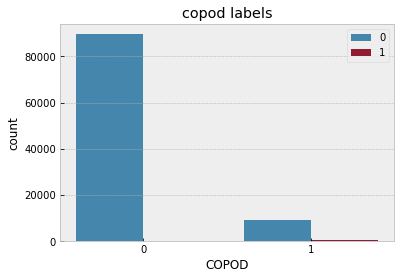

In [100]:
sns.countplot(data=valid, x='COPOD', hue='is_duplicate')
plt.title('copod labels')
plt.legend();

# Feature search

In [101]:
# init
exclude_columns = ['name_1', 'name_2', 'name_1_joined', 'name_2_joined', '4_str']
columns = train.drop(exclude_columns + ['is_duplicate'], axis=1).columns

params = {"iterations": 1000,
#          "depth": 2,
          "loss_function": "CrossEntropy",
          "verbose": False,
          "eval_metric": "F1",
          "random_seed": RS,
          "learning_rate": 0.5,
#          "auto_class_weights": 'Balanced',
          "use_best_model": True,
#          "l2_leaf_reg": 300
          }

columns

Index([              'levenstein',          'norm_levenstein',
                        'jaccard',                  'ngramms',
                         '1_in_2',                   '2_in_1',
                 'jaccard_joined',        'levenstein_joined',
         'norm_levenstein_joined',                'num_chars',
                      'num_words',              'subseq_rate',
                   'word_compare',           'sum_word_index',
                        'damerau', 'optimal_string_alignment',
                    'jarowinkler',               'lcs_length',
                   'lcs_distance',               'metric_lcs',
                        'twogram',                    'qgram',
                           'sift',                'lr_labels',
                                0,                          1,
                                2,                          3,
                                4,                          5,
                                6,                     

In [102]:
def random_selection(n_iters):
    best_score = 0
    for i in tqdm(range(n_iters)):
        features = np.random.choice(columns, size=np.random.randint(1, len(columns)), replace=False)
    
        X_train = train[features].values
        y_train = train['is_duplicate'].values
        train_data = Pool(X_train, y_train)
    
        X_valid = valid[features].values
        y_valid = valid['is_duplicate'].values
        valid_data = Pool(X_valid, y_valid)

        model = CatBoostClassifier(**params)
        model.fit(train_data, eval_set=valid_data)
    
        preds = model.predict(X_valid)
        score = f1_score(y_valid, preds)
    
        if score > best_score:
            best_score = score
            print('best_score', best_score)
            best_features = features
    return best_features

In [103]:
#best_features = random_selection(100)
#best_features = ['qgram', 18, 'ngramms', '2_in_1', 6, 7, 'sum_word_index', 'sift',
#                 2, 5, '1_in_2', 'jaccard', 12, 'metric_lcs', 'jaccard_joined',
#                 'subseq_rate', 'lcs_distance', 'damerau']
best_features = columns

array(['num_words', '2_in_1', 13, 9, 1, 'sift', 'sum_word_index',
       'metric_lcs', 11, 'word_compare', 10, 15, 3, 16, '1_in_2',
       'norm_levenstein_joined', 'ngramms', 'levenstein', 2, 12,
       'jaccard_joined', 6, 'jarowinkler', 'levenstein_joined',
       'lcs_length', 'lcs_distance', 18, 'damerau', 0, 5, 8], dtype=object)

# linear regression

In [112]:
X_train = train[best_features].values
y_train = train['is_duplicate'].values

X_valid = valid[best_features].values
y_valid = valid['is_duplicate'].values

X_test = test[best_features].values

X_train_scaled, X_valid_scaled, X_test_scaled = scale(X_train, X_valid, X_test, scaler)

In [116]:
cols = ['name_1', 'name_2']
X_train = train[cols].values
X_valid = valid[cols].values
X_test = test[cols].values

X_train_vectorized, X_valid_vectorized, X_test_vectorized = vectorize(X_train, X_valid, X_test, vectorizer)

In [117]:
X_train_sp = sparse.csr_matrix(X_train_scaled)
X_valid_sp = sparse.csr_matrix(X_valid_scaled)
X_test_sp = sparse.csr_matrix(X_test_scaled)

In [118]:
X_train = sparse.hstack([X_train_sp, X_train_vectorized])
X_valid = sparse.hstack([X_valid_sp, X_valid_vectorized])
X_test = sparse.hstack([X_test_sp, X_test_vectorized])
X_train.shape, X_valid.shape, X_test.shape

((348990, 5044), (99563, 5044), (213249, 5044))

In [124]:
ITER = 100
best_score = 0
for i in tqdm(range(ITER)):
    weight = np.random.random()
    class_weight = {0: weight,
                    1: 1 - weight}
   
    lr = LogisticRegression(random_state=RS, class_weight=class_weight, C=0.1,
                            n_jobs=-1).fit(X_train, y_train)
    preds = lr.predict(X_valid)
    score = f1_score(y_valid, preds)
    if score > best_score:
        best_score = score
        print(f'C = {C}, score = {score:.2f}, weight_0 = {weight:.2f}')

C = 1000.0, score = 0.64, weight_0 = 0.16
C = 1000.0, score = 0.64, weight_0 = 0.20
C = 1000.0, score = 0.64, weight_0 = 0.11



In [137]:
def preprocess(train, valid, test, features, vectorizer):
    X_train = train[features].values
    y_train = train['is_duplicate'].values

    X_valid = valid[features].values
    y_valid = valid['is_duplicate'].values

    X_test = test[features].values
    
    scaler = RobustScaler()
    X_train_scaled, X_valid_scaled, X_test_scaled = scale(X_train, X_valid, X_test, scaler)
    
    cols = ['name_1', 'name_2']
    X_train = train[cols].values
    X_valid = valid[cols].values
    X_test = test[cols].values

    X_train_vectorized, X_valid_vectorized, X_test_vectorized = vectorize(X_train, X_valid, X_test, vectorizer)
    
    X_train_sp = sparse.csr_matrix(X_train_scaled)
    X_valid_sp = sparse.csr_matrix(X_valid_scaled)
    X_test_sp = sparse.csr_matrix(X_test_scaled)
    
    X_train = sparse.hstack([X_train_sp, X_train_vectorized])
    X_valid = sparse.hstack([X_valid_sp, X_valid_vectorized])
    X_test = sparse.hstack([X_test_sp, X_test_vectorized])
    
    return X_train, y_train, X_valid, y_valid, X_test

In [139]:
ITER = 0
best_score = 0
best_features = columns
for i in tqdm(range(ITER)):
    features = np.random.choice(columns, size=np.random.randint(1, len(columns)), replace=False) 
    ngram_range = np.random.randint(1,4)
    ngram_range_2 = ngram_range + np.random.randint(0,5)
    max_features = np.random.randint(3,100) * 1000
    
    vectorizer = CountVectorizer(analyzer='char', ngram_range=(ngram_range, ngram_range_2), max_features=max_features)
    X_train, y_train, X_valid, y_valid, X_test = preprocess(train, valid, test, features, vectorizer)
    
    weight = 0.11
    class_weight = {0: weight,
                    1: 1 - weight}
   
    lr = LogisticRegression(random_state=RS, class_weight=class_weight, C=0.1,
                            n_jobs=-1).fit(X_train, y_train)
    preds = lr.predict(X_valid)
    score = f1_score(y_valid, preds)
    if score > best_score:
        best_score = score
        best_features = features
        print(f'score = {score:.2f}, weight_0 = {weight:.2f}, ngram_range = {ngram_range, ngram_range_2}, max_features = {max_features}')
best_features

C = 1000.0, score = 0.64, weight_0 = 0.11, ngram_range = (2, 3), max_features = 91000
C = 1000.0, score = 0.74, weight_0 = 0.11, ngram_range = (2, 4), max_features = 10000
C = 1000.0, score = 0.74, weight_0 = 0.11, ngram_range = (2, 4), max_features = 50000



array(['1_in_2', 5, 'levenstein_joined', 'jarowinkler', 'jaccard_joined',
       15, 7, 'sift', 'lcs_length', 'word_compare', 0, 'sum_word_index',
       'ngramms', 'num_words', 6, 17, 'COPOD', 'levenstein',
       'norm_levenstein_joined', 16, 3, '2_in_1', 11, 14, 9, 'twogram',
       18, 'damerau', 'jaccard', 8, 'lcs_distance', 'subseq_rate', 10, 12,
       'metric_lcs'], dtype=object)

In [141]:
features = ['1_in_2', 5, 'levenstein_joined', 'jarowinkler', 'jaccard_joined',
            15, 7, 'sift', 'lcs_length', 'word_compare', 0, 'sum_word_index',
            'ngramms', 'num_words', 6, 17, 'COPOD', 'levenstein',
            'norm_levenstein_joined', 16, 3, '2_in_1', 11, 14, 9, 'twogram',
            18, 'damerau', 'jaccard', 8, 'lcs_distance', 'subseq_rate', 10, 12,
            'metric_lcs']
vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 4), max_features=50000)
weight = 0.11
class_weight = {0: weight,
                1: 1 - weight}
    
X_train, y_train, X_valid, y_valid, X_test = preprocess(pd.concat([train, valid], axis=0), valid, test, features, vectorizer)

In [143]:
model = LogisticRegression(random_state=RS, class_weight=class_weight, C=0.1,
                           n_jobs=-1).fit(X_train, y_train)

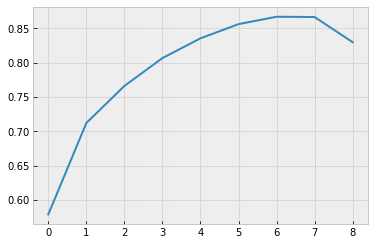

In [144]:
preds = model.predict_proba(X_valid)[:, 1]
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
metrics = []
for thr in thresholds:
    labels = (preds > thr).astype(int)
    #print('-' * 10, 'THRESHOLD =', thr, '-' * 10)
    #print(classification_report(y_valid, labels))
    #print()
    metric = f1_score(y_valid, labels)
    metrics.append(metric)
plt.plot(metrics)

In [ ]:
#X_train = train[columns].values
#y_train = train['is_duplicate'].values
#train_data = Pool(X_train, y_train)

In [ ]:
#params['use_best_model'] = False
#params['iterations'] = 200
#model = CatBoostClassifier(**params)
#model.fit(train_data, plot=True)

# Training on full data

In [ ]:
train_full = pd.concat([train, valid], axis=0)
X_train = train_full[best_features].values
y_train = train_full['is_duplicate'].values
train_data = Pool(X_train, y_train)
X_train.shape, y_train.shape

In [ ]:
params['use_best_model'] = False
model = CatBoostClassifier(**params)
model.fit(train_data, plot=True)

# Submit

In [145]:
def submit(preds, threshold=0.5, filename='submit.csv', dataset=test):
    labels = (preds > threshold).astype(int)
    result = pd.DataFrame({'pair_id': dataset.index,
                           'is_duplicate': labels})
    print(f'Число положительных классов для threshold={threshold}: {result["is_duplicate"].sum()} / {result["is_duplicate"].mean():.2%}')
    result.to_csv(filename, index=False)
    print('Done!')
    return result

In [146]:
preds = model.predict_proba(X_test)[:, 1]
results = []
for thr in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    filename = f'submit_{thr}.csv'
    res = submit(preds, threshold=thr, filename=filename, dataset=test)
    results.append(res)

Число положительных классов для threshold=0.1: 3407 / 1.60%
Done!
Число положительных классов для threshold=0.2: 2255 / 1.06%
Done!
Число положительных классов для threshold=0.3: 1930 / 0.91%
Done!
Число положительных классов для threshold=0.4: 1716 / 0.80%
Done!
Число положительных классов для threshold=0.5: 1512 / 0.71%
Done!
Число положительных классов для threshold=0.6: 1355 / 0.64%
Done!
Число положительных классов для threshold=0.7: 1150 / 0.54%
Done!
Число положительных классов для threshold=0.8: 965 / 0.45%
Done!
Число положительных классов для threshold=0.9: 661 / 0.31%
Done!


# Ручная валидация

In [147]:
idx = results[6][results[6]['is_duplicate'] == 1]['pair_id']
test = pd.read_csv(TEST_PATH, index_col=0)
test.loc[idx, ['name_1', 'name_2']].sample(25)

,name_1,name_2
pair_id,,
201742,Goodyear Canada Inc.,Goodyear Dunlop Tires North America Ltd.
131830,Lg Chem America Inc.,Lg Chem America
54695,S J Rubber Industries Ltd.,J K Tyre & Industries Ltd.
129502,Saint Gobain Ppl Korea 2 Nd Plant,Saint Gobain Vietnam Ltd.
830,Mol Logistics (Usa.) Inc.Dallas,Mol Logistics (Deutschland) Gmb H
26923,E Land Retail,Land Mark Srl #1343
124638,"ООО ""ХИМИНВЕСТ НПФ""",ООО Химинвест групп
100683,Panalpina,Panalpina World Transport Nakliyat
34680,BAZALT GROUP (DORTMUNDER GUSSASPHALT GMBH & CO...,Dortmunder Gussasphalt GmbH & Co. KG
